## Performs splines regression on net photosynthetic rate data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from patsy import bs, dmatrix

import arviz as az

import pymc3 as pm

In [3]:
net_photosynthetic_rate = pd.read_csv("../data/soybean_net_photosynthetic_rate.csv", 
                                      index_col="Photosynthetically Active Radiation [micromol / m^2 / s]")

In [4]:
net_photosynthetic_rate

,Monocropping - CO2 uptake [micromol / m^2 / s],Intercropping - CO2 uptake [micromol / m^2 / s]
Photosynthetically Active Radiation [micromol / m^2 / s],,
0.0,-3.5,-2.5
25.0,-2.7,-0.7
50.0,-0.9,0.8
75.0,1.0,2.3
100.0,2.0,3.0
200.0,6.0,7.0
400.0,12.5,11.0
600.0,17.0,12.5
800.0,20.0,14.5


In [5]:
net_photosynthetic_rate.rename(columns ={'Monocropping - CO2 uptake [micromol / m^2 / s]': 'Monocropping', 
                                         'Intercropping - CO2 uptake [micromol / m^2 / s]': 'Intercropping'},
                               inplace=True)

In [6]:
net_photosynthetic_rate

,Monocropping,Intercropping
Photosynthetically Active Radiation [micromol / m^2 / s],,
0.0,-3.5,-2.5
25.0,-2.7,-0.7
50.0,-0.9,0.8
75.0,1.0,2.3
100.0,2.0,3.0
200.0,6.0,7.0
400.0,12.5,11.0
600.0,17.0,12.5
800.0,20.0,14.5


In [7]:
net_photosynthetic_rate.index.names = ['PAR']

In [8]:
net_photosynthetic_rate

,Monocropping,Intercropping
PAR,,
0.0,-3.5,-2.5
25.0,-2.7,-0.7
50.0,-0.9,0.8
75.0,1.0,2.3
100.0,2.0,3.0
200.0,6.0,7.0
400.0,12.5,11.0
600.0,17.0,12.5
800.0,20.0,14.5


In [9]:
par = net_photosynthetic_rate.index.values

In [10]:
par

array([   0.,   25.,   50.,   75.,  100.,  200.,  400.,  600.,  800.,
       1000., 1200., 1500.])

In [11]:
co2_uptake_monocropping = net_photosynthetic_rate.Monocropping.values

In [12]:
co2_uptake_monocropping

array([-3.5, -2.7, -0.9,  1. ,  2. ,  6. , 12.5, 17. , 20. , 22. , 23.5,
       25. ])

In [13]:
co2_uptake_intercropping = net_photosynthetic_rate.Intercropping.values

In [14]:
co2_uptake_intercropping

array([-2.5, -0.7,  0.8,  2.3,  3. ,  7. , 11. , 12.5, 14.5, 15.5, 16. ,
       17. ])

In [45]:
cropping_types = ['Monocropping', 'Intercropping']

### Modelling preparation

In [24]:
num_knots = 2

In [25]:
knot_list = np.linspace(par[0], par[-1], num_knots+2)[1:-1]

In [26]:
knot_list

array([ 500., 1000.])

In [58]:
index = range(2)

In [59]:
groups = len(index)

### First model - Global

In [27]:
par_global = np.concatenate([par, par], axis=0)

In [28]:
par_global

array([   0.,   25.,   50.,   75.,  100.,  200.,  400.,  600.,  800.,
       1000., 1200., 1500.,    0.,   25.,   50.,   75.,  100.,  200.,
        400.,  600.,  800., 1000., 1200., 1500.])

In [29]:
co2_uptake_global = np.concatenate([co2_uptake_monocropping, co2_uptake_intercropping], axis=0)

In [30]:
co2_uptake_global

array([-3.5, -2.7, -0.9,  1. ,  2. ,  6. , 12.5, 17. , 20. , 22. , 23.5,
       25. , -2.5, -0.7,  0.8,  2.3,  3. ,  7. , 11. , 12.5, 14.5, 15.5,
       16. , 17. ])

In [41]:
co2_uptake_global.shape

(24,)

In [32]:
b_global = dmatrix(
     "bs(par, knots=knots, degree=3, include_intercept=True) - 1",
     {"par": par_global, "knots": knot_list})

In [33]:
b_global

DesignMatrix with shape (24, 6)
  Columns:
    ['bs(par, knots=knots, degree=3, include_intercept=True)[0]',
     'bs(par, knots=knots, degree=3, include_intercept=True)[1]',
     'bs(par, knots=knots, degree=3, include_intercept=True)[2]',
     'bs(par, knots=knots, degree=3, include_intercept=True)[3]',
     'bs(par, knots=knots, degree=3, include_intercept=True)[4]',
     'bs(par, knots=knots, degree=3, include_intercept=True)[5]']
  Terms:
    'bs(par, knots=knots, degree=3, include_intercept=True)' (columns 0:6)
  (to view full data, use np.asarray(this_obj))

In [35]:
with pm.Model() as sp_global:
    τ = pm.HalfCauchy('τ', 1)
    β = pm.Normal("β", mu=0, sd=τ, shape=b_global.shape[1])
    μg = pm.Deterministic("μg", pm.math.dot(np.asfortranarray(b_global), β))
    σ = pm.HalfNormal("σ", 1)
    up = pm.Normal("up", μg, σ, observed=co2_uptake_global)
    idata_sp_global = pm.sample(3000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β, τ]


Sampling 2 chains for 2_000 tune and 3_000 draw iterations (4_000 + 6_000 draws total) took 30 seconds.


In [36]:
idata_sp_global

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [37]:
μsg = idata_sp_global.posterior.stack(draws=("chain", "draw"))["μg"].values.T

In [38]:
μsg

array([[-2.97253054, -1.41412503,  0.05748096, ..., 18.45053419,
        21.35099341, 15.57346951],
       [-2.43896567, -1.0539024 ,  0.22601209, ..., 19.73915362,
        19.01961442, 24.24074682],
       [-3.20677251, -1.84324014, -0.53756256, ..., 18.65742669,
        20.07711799, 17.86455258],
       ...,
       [-2.96734604, -1.59790991, -0.29792998, ..., 18.83295198,
        19.22218149, 18.95131434],
       [-3.32717652, -1.46857537,  0.22135351, ..., 19.36062494,
        17.96295794, 21.31697567],
       [-2.57543351, -1.39293648, -0.26520063, ..., 19.55396553,
        18.88057121, 22.0760845 ]])

In [39]:
μsg_mean = μsg.mean(0)

In [40]:
μsg_mean

array([-3.03329172, -1.47279364, -0.02466457,  1.31669507,  2.55688483,
        6.61793679, 11.58615825, 14.67172141, 17.14239302, 18.73335778,
       19.37436696, 20.76817484, -3.03329172, -1.47279364, -0.02466457,
        1.31669507,  2.55688483,  6.61793679, 11.58615825, 14.67172141,
       17.14239302, 18.73335778, 19.37436696, 20.76817484])

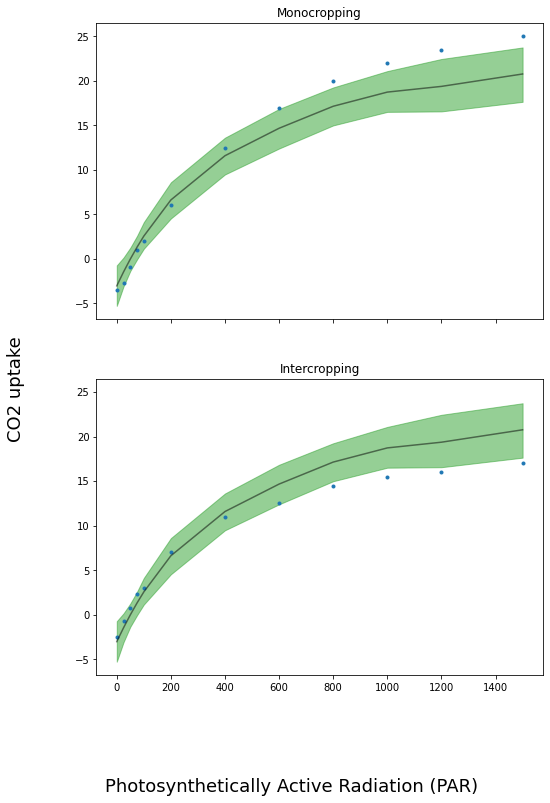

In [54]:
fig, axes = plt.subplots(2, 1, figsize=(8, 12), sharey=True, sharex=True)

for count, (idx, ax) in enumerate(zip(range(0, 24, 12), axes.ravel())):
    ax.plot(par, co2_uptake_global[idx:idx+12], '.', lw=1)
    ax.plot(par, μsg_mean[idx:idx+12], "k", alpha=0.5);
    az.plot_hdi(par, μsg[:,idx:idx+12], color="C2", smooth=False, ax=ax)
    ax.set_title(cropping_types[count])

fig.text(0.14, -0.01, "Photosynthetically Active Radiation (PAR)", size=18)
fig.text(-0.03, 0.4, "CO2 uptake", size=18, rotation=90)
         
plt.savefig("../plots/net_photosynthetic_rate/co2_uptake_global_splines_fit.png", bbox_inches='tight')

### Second model - Individual

In [55]:
b_individual = dmatrix(
     "bs(par, knots=knots, degree=3, include_intercept=True) - 1",
     {"par": par, "knots": knot_list})

In [56]:
b_individual

DesignMatrix with shape (12, 6)
  Columns:
    ['bs(par, knots=knots, degree=3, include_intercept=True)[0]',
     'bs(par, knots=knots, degree=3, include_intercept=True)[1]',
     'bs(par, knots=knots, degree=3, include_intercept=True)[2]',
     'bs(par, knots=knots, degree=3, include_intercept=True)[3]',
     'bs(par, knots=knots, degree=3, include_intercept=True)[4]',
     'bs(par, knots=knots, degree=3, include_intercept=True)[5]']
  Terms:
    'bs(par, knots=knots, degree=3, include_intercept=True)' (columns 0:6)
  (to view full data, use np.asarray(this_obj))

In [60]:
with pm.Model() as sp_individual:
    τ = pm.HalfCauchy("τ", 1)
    β = pm.Normal("β", mu=0, sigma=τ, shape=(b_individual.shape[1], groups)) 
    μi = pm.Deterministic("μi", pm.math.dot(np.asfortranarray(b_individual), β))
    σ = pm.HalfNormal("σ", 1)
    up = pm.Normal("up", μi[:,index].T.ravel(), σ, observed=co2_uptake_global) 
    idata_sp_individual = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β, τ]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 26 seconds.


In [61]:
μsi = idata_sp_individual.posterior.stack(draws=("chain", "draw"))["μi"].values.T

In [62]:
μsi_mean = μsi.mean(0)

In [63]:
μsi_mean

array([[-3.66710119, -2.19271647, -0.79265493,  0.5359077 ,  1.79579571,
         6.20508713, 12.58586963, 16.89598596, 19.97444852, 22.07854253,
        23.46498458, 24.98467793],
       [-2.39415441, -0.76713064,  0.71762426,  2.06771422,  3.2907432 ,
         7.06432809, 10.82416943, 12.68819488, 14.38016513, 15.54477626,
        15.97718476, 16.98756652]])

/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


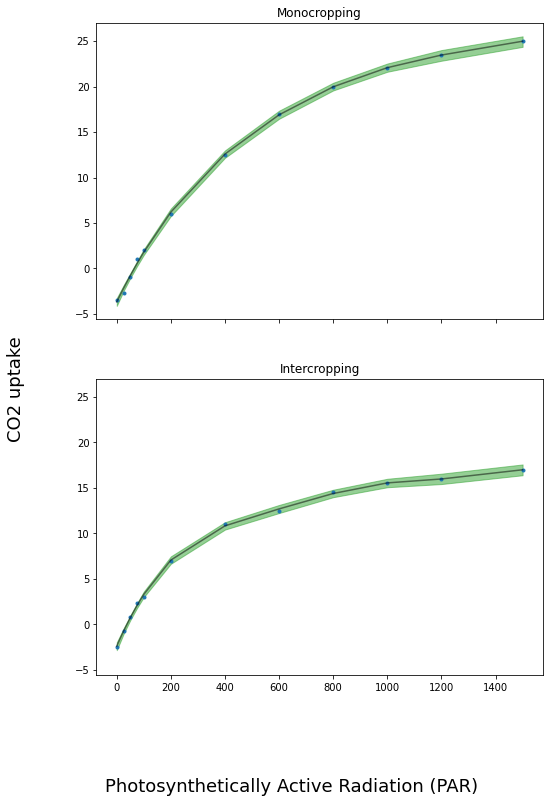

In [65]:
fig, axes = plt.subplots(2, 1, figsize=(8, 12), sharey=True, sharex=True)

for count, (idx, ax) in enumerate(zip(range(0, 24, 12), axes.ravel())):
    ax.plot(par, co2_uptake_global[idx:idx+12], '.', lw=1)
    ax.plot(par, μsi_mean[index[count]], "k", alpha=0.5);
    az.plot_hdi(par, μsi[:,index[count]], color="C2", smooth=False, ax=ax)
    ax.set_title(cropping_types[count])

fig.text(0.14, -0.01, "Photosynthetically Active Radiation (PAR)", size=18)
fig.text(-0.03, 0.4, "CO2 uptake", size=18, rotation=90)
         
plt.savefig("../plots/net_photosynthetic_rate/co2_uptake_individual_splines_fit.png", bbox_inches='tight')

### Third model - Mix

In [66]:
with pm.Model() as sp_mix:
    τ = pm.HalfCauchy('τ', 1)
    β = pm.Normal("β", mu=0, sd=τ, shape=b_global.shape[1])
    μg = pm.Deterministic("μg", pm.math.dot(np.asfortranarray(b_global), β))
    βi = pm.Normal("βi", mu=0, sd=τ, shape=(b_individual.shape[1], groups))
    μi = pm.Deterministic("μi", pm.math.dot(np.asfortranarray(b_individual), βi))
    σ = pm.HalfNormal("σ", 1)
    up = pm.Normal("up", μg+μi[:,index].T.ravel(), σ, observed=co2_uptake_global)
    idata_sp_mix = pm.sample(3000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, βi, β, τ]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 232 seconds.
There were 148 divergences after tuning. Increase `target_accept` or reparameterize.
There were 627 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [67]:
μsg = idata_sp_mix.posterior.stack(draws=("chain", "draw"))["μg"].values.T

In [68]:
μsg_mean = μsg.mean(0)

In [69]:
μsi = idata_sp_mix.posterior.stack(draws=("chain", "draw"))["μi"].values.T

In [70]:
μsi_mean = μsi.mean(0)

/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


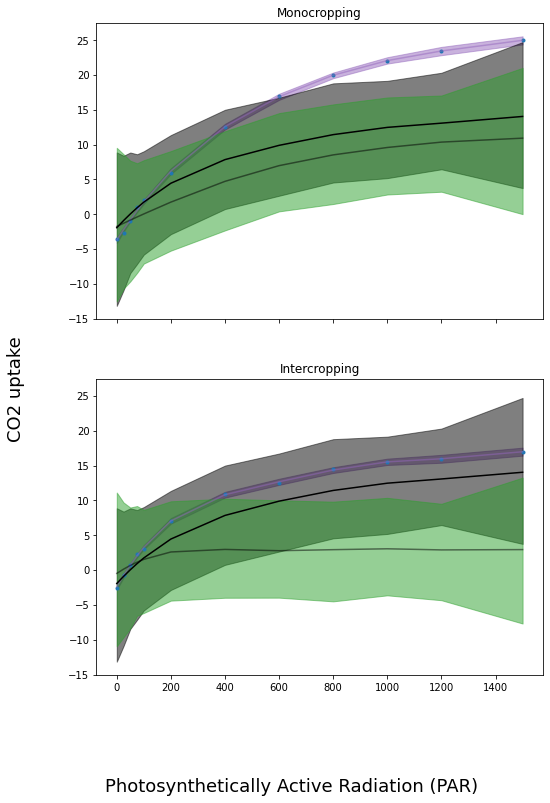

In [71]:
fig, axes = plt.subplots(2, 1, figsize=(8, 12), sharey=True, sharex=True)

for count, (idx, ax) in enumerate(zip(range(0, 24, 12), axes.ravel())):
    ax.plot(par, co2_uptake_global[idx:idx+12], '.', lw=1)
    ax.plot(par, μsg_mean[idx:idx+12] + μsi_mean[index[count]], "C4", alpha=0.5);
    az.plot_hdi(par, μsg[:,idx:idx+12] + μsi[:,index[count]], color="C4", smooth=False, ax=ax)
    ax.plot(par, μsg_mean[idx:idx+12], "k");
    az.plot_hdi(par, μsg[:,idx:idx+12], color="k", smooth=False, ax=ax)
    ax.plot(par, μsi_mean[index[count]], "k", alpha=0.5);
    az.plot_hdi(par, μsi[:,index[count]], color="C2", smooth=False, ax=ax)
    ax.set_title(cropping_types[count])

fig.text(0.14, -0.01, "Photosynthetically Active Radiation (PAR)", size=18)
fig.text(-0.03, 0.4, "CO2 uptake", size=18, rotation=90)
         
plt.savefig("../plots/net_photosynthetic_rate/co2_uptake_mix_splines_fit.png", bbox_inches='tight')

### Model comparison

In [72]:
cmp = az.compare({"sp_global":idata_sp_global,
                  "sp_individual":idata_sp_individual,
                  "sp_mix":idata_sp_mix})

/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a n

In [73]:
cmp

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
sp_mix,0,-11.330046,9.824422,0.000000,1.0,2.560527,0.000000,True,log
sp_individual,1,-12.045504,10.642049,0.715458,0.0,2.936243,0.585585,True,log
sp_global,2,-64.299165,11.701762,52.969118,0.0,5.645131,5.526688,True,log


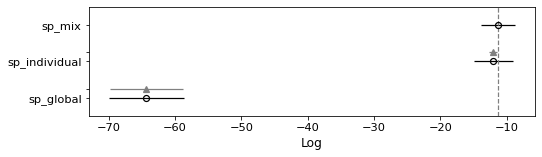

In [74]:
az.plot_compare(cmp, insample_dev=False, figsize=(8, 2))
plt.savefig("../plots/net_photosynthetic_rate/co2_uptake_splines_fit_sp_compare.png")